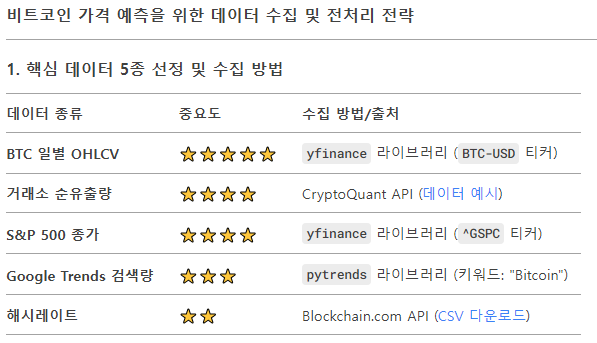

In [1]:
!pip install pytrends

필수 라이브러리 임포트

In [2]:
import pandas as pd
import requests
import numpy as np
import yfinance as yf
from pytrends.request import TrendReq
from sklearn.preprocessing import MinMaxScaler

데이터 수집 - 5년치 일별 데이터 (2019-01-01 ~ 2024-12-31)

In [4]:
def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:

    if isinstance(df.columns, pd.MultiIndex):

        df.columns = ['_'.join([str(c) for c in col_tuple if c]) for col_tuple in df.columns.values]
    else:
        df.columns = [str(c) for c in df.columns]

    # index -> column
    df.reset_index(drop=False, inplace=True)
    return df


# 1. BTC OHLCV (Open, High, Low, Close, Volume)
btc = yf.download('BTC-USD', start='2019-01-01', end='2024-12-31', progress=False)
btc = btc[['Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'btc_open', 'High': 'btc_high', 'Low': 'btc_low',
    'Close': 'btc_close', 'Volume': 'btc_volume'
})
btc = flatten_columns(btc)

# 2. S&P 500 종가
sp500 = yf.download("^GSPC", start='2019-01-01', end='2024-12-31', progress=False)
sp500.rename(columns={
    "Open": "sp500_open",
    "High": "sp500_high",
    "Low": "sp500_low",
    "Close": "sp500_close",
    "Volume": "sp500_volume"
}, inplace=True)

# sp500_close 컬럼만 남기고 나머지 컬럼은 제거
sp500 = sp500[["sp500_close"]]
sp500_close = flatten_columns(sp500)

# 3. Google Trends 검색량 (주간 데이터 → 일별 보간)
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(kw_list=['Bitcoin'], timeframe='2019-01-01 2024-12-31')
trends = pytrends.interest_over_time().drop(columns=['isPartial'])

# Make sure the 'Date' is retained as a column before interpolation
trends = trends.reset_index()

# Set 'date' as the index for resampling
trends.set_index('date', inplace=True)

# Resample and interpolate
trends = trends.resample('D').interpolate(method='linear')

trends.columns = ['google_trend']  # Rename columns to match expected output
trends = flatten_columns(trends)
trends.rename(columns={'date': 'Date'}, inplace=True)  # 변경: 소문자 'date'를 'Date'로

# 4. 해시레이트 - from IntoTheBlock
# https://app.intotheblock.com/coin/BTC/deep-dive?group=mining&subgroup=hashRate
hash_rate = pd.read_csv("final_hashrate.csv", parse_dates=['Date'], index_col='Date')
hash_rate.rename(columns={'HashRate': 'btc_hashrate'}, inplace=True)
hash_rate = flatten_columns(hash_rate)

# 5. 거래소 순유출량 - from IntoTheBlock
# https://app.intotheblock.com/coin/BTC/deep-dive?group=exchanges&subgroup=on-chain-flows&chart=net-flows
exchange_flow = pd.read_csv("final_Exchanges_netflow.csv", parse_dates=['Date'], index_col='Date')
exchange_flow.rename(columns={'Total_Exchanges_netflow': 'btc_exchange_netflow'}, inplace=True)
exchange_flow = flatten_columns(exchange_flow)

3. 데이터 병합 및 전처리

In [8]:
# 모든 데이터 병합
merged_df = btc.copy()
merged_df = merged_df.merge(sp500_close, on='Date', how='left')
merged_df = merged_df.merge(trends, on='Date', how='left')
merged_df = merged_df.merge(hash_rate, on='Date', how='left')
merged_df = merged_df.merge(exchange_flow, on='Date', how='left')

# 병합된 데이터 확인
print(merged_df.head())
print(merged_df.tail())

        Date  btc_open_BTC-USD  btc_high_BTC-USD  btc_low_BTC-USD  \
0 2019-01-01       3746.713379       3850.913818      3707.231201   
1 2019-01-02       3849.216309       3947.981201      3817.409424   
2 2019-01-03       3931.048584       3935.685059      3826.222900   
3 2019-01-04       3832.040039       3865.934570      3783.853760   
4 2019-01-05       3851.973877       3904.903076      3836.900146   

   btc_close_BTC-USD  btc_volume_BTC-USD  sp500_close_^GSPC  google_trend  \
0        3843.520020          4324200990                NaN          15.0   
1        3943.409424          5244856836        2510.030029          15.0   
2        3836.741211          4530215219        2447.889893          15.0   
3        3857.717529          4847965467        2531.939941          15.0   
4        3845.194580          5137609824                NaN          15.0   

   btc_hashrate  btc_exchange_netflow  
0     41.826597          -2626.325920  
1     42.361559          -5017.271304  
2 

In [22]:
# merged_df 복사
df = merged_df.copy()

# 1. Date 컬럼을 datetime으로 변환하고 인덱스로 설정
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# 2. 결측치 처리: 전날 값(f.fill()) 및 선형 보간(interpolate)
df = df.ffill()               # 전날 값을 이용하여 결측치 채우기
df = df.interpolate(method='linear') # 선형 보간

# 3. 이상치 처리 (IQR 기준)
def clip_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series.clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

df = df.apply(clip_outliers)

# 4. 시계열 인덱스 설정: 이미 Date 컬럼을 인덱스로 설정했으므로,
#    asfreq('D')를 사용해 일별 빈도로 맞추고 정렬.
# 중복된 Date 인덱스가 있으면 첫 번째 값만 남기도록 제거
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq('D').sort_index()

4. 피처 엔지니어링

In [23]:
# 기술적 지표 추가
df['ma7'] = df['btc_close_BTC-USD'].rolling(window=7).mean()  # 7일 이동평균
df['ma21'] = df['btc_close_BTC-USD'].rolling(window=21).mean()  # 21일 이동평균

# RSI 계산 (14일 기준)
delta = df['btc_close_BTC-USD'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))
df['rsi_14'] = rsi

# 변동률 계산
df['sp500_ret'] = df['sp500_close_^GSPC'].pct_change()  # S&P 500 일별 수익률
df['hash_rate_chg'] = df['btc_hashrate'].pct_change(30)  # 해시레이트 30일 변동률
df['exchange_netflow_chg'] = df['btc_exchange_netflow'].pct_change(30)  # 거래소 순유출량 30일 변동률

# 맨앞에 남아있는 NaN은 이전의 데이터가 없기때문에 바로 다음 값(bfill)으로 채움
df = df.fillna(method='ffill').fillna(method='bfill')

<ipython-input-23-5e0f3604d637>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


5. 데이터 분할 (Time-Series Split)

In [24]:
# 테스트용 데이터 분할 설정 (학습 70%, val 15%, test 15%)
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

6. CSV 저장

In [25]:
df.to_csv('DeepSeek_data.csv')

print("최종 데이터 형태:", df.shape)
print("컬럼 목록:", df.columns.tolist())
print(f"- 기간: {df.index.min()} ~ {df.index.max()}")
print(f"- 컬럼 수: {len(df.columns)}")
print(f"- 샘플 컬럼: {df.columns[:5].tolist()}...")

최종 데이터 형태: (2191, 15)
컬럼 목록: ['btc_open_BTC-USD', 'btc_high_BTC-USD', 'btc_low_BTC-USD', 'btc_close_BTC-USD', 'btc_volume_BTC-USD', 'sp500_close_^GSPC', 'google_trend', 'btc_hashrate', 'btc_exchange_netflow', 'ma7', 'ma21', 'rsi_14', 'sp500_ret', 'hash_rate_chg', 'exchange_netflow_chg']
- 기간: 2019-01-01 00:00:00 ~ 2024-12-30 00:00:00
- 컬럼 수: 15
- 샘플 컬럼: ['btc_open_BTC-USD', 'btc_high_BTC-USD', 'btc_low_BTC-USD', 'btc_close_BTC-USD', 'btc_volume_BTC-USD']...




---


1.비트코인 일별 OHLCV (가격 및 거래량)

중요도: ⭐⭐⭐⭐⭐

설명:

OHLCV (시가, 고가, 저가, 종가, 거래량)는 가격 추세와 시장 유동성을 직접 반영합니다.

단기 변동성과 장기 추세 분석의 기초 데이터로 필수적입니다.



---



2.거래소 순유출량 (Exchange Netflow)

중요도: ⭐⭐⭐⭐

설명:

거래소에서 유출된 BTC 양에서 유입된 양을 뺀 값 (순유출량)은 대형 투자자(고래)의 매수/매도 신호로 활용됩니다.

순유출량 ↑ → 장기 보관 증가 (가격 상승 전조).



---



3.S&P 500 종가 (주식 시장 지표)

중요도: ⭐⭐⭐⭐

설명:

비트코인은 주식 시장 (특히 테크 주식)과 높은 상관관계를 보입니다.

S&P 500의 하락 → 리스크 오프 → BTC 매도 압력 증가 가능성.



---



4.구글 트랜드 검색량

중요도: ⭐⭐⭐
설명:

대표적인 검색 포털 구글에서의 검색량 상승 ↑ → 단기 가격 상승 가능성



---




5.해시레이트 (Hashrate)

중요도: ⭐⭐

설명:

비트코인 네트워크의 채굴 난이도와 보안 수준을 반영합니다.

해시레이트 급락 → 마이너 매도 → 가격 하락 가능성.

## 데이터 요약

### 기간 및 범위
- **기간**: 2019년 1월 1일 ~ 2024년 12월 31일

### 비트코인 가격 변동
- **최저가**: $3,400.82 (2019년 1월 29일)
- **최고가**: $100,269.95 (2024년 12월 8일)

### 주요 지표
- **거래량 (Volume)**: 일일 평균 약 20B ~ 30B. 특정 구간(예: 2019년 6월, 2020년 2월)에서 $40B 이상의 폭발적 증가 관찰.
- **RSI (14일)**: 대부분 30~70 범위. 70 이상(과매수) 및 30 이하(과매도) 구간이 산발적으로 발생.
- **이동평균 (MA7/MA21)**: MA7이 MA21 위로 상승하는 "골든크로스" 구간에서 가격 상승 추세 확인.

### 외부 요인 연관성
- **S&P 500**: 2,500~3,400 포인트 범위. 2020년 2월 COVID-19 영향으로 하락세 시작.
- **구글 트렌드**: 15~25 범위. 특정 이벤트(예: 2019년 6월 가격 급등)와 검색량 증가 연관성 있음.

### 네트워크 지표
- **해시레이트 (Hashrate)**: 40 EH/s ~ 120 EH/s로 꾸준히 증가. 2020년 2월 기준 110 EH/s 부근.
- **거래소 순유입**: 순유입 변동성이 큼. 마이너스 값(유출)은 가격 하락과 연관성 있음.

### 주요 이벤트
- **2019년 6월**: 비트코인 가격 $13,000 돌파 (구글 트렌드 90 이상 급증).
- **2020년 2월**: S&P 500과 함께 급락 시작 (COVID-19 영향).

---

## 시사점

### 전반적인 가격 상승 추세
분석 기간 동안 비트코인 가격은 전반적으로 크게 상승하는 추세를 보였습니다. 특히 2020년 말부터 2021년까지, 그리고 2023년부터 2024년까지 뚜렷한 상승세를 나타냈습니다.

### 변동성
비트코인 가격은 단기적으로 큰 변동성을 보이는 특징을 유지했습니다. 급격한 상승과 하락이 반복되는 패턴을 확인할 수 있습니다.

### 가격 급등 시기
- **2020년 말 - 2021년**: 코로나19 팬데믹 이후, 기관 투자자들의 참여 증가와 함께 비트코인 가격이 크게 상승.
- **2023년 - 2024년**: 금리 인상 둔화 기대감, 현물 ETF 승인 기대감 등으로 강한 상승세를 보였습니다.

### 가격 급락 시기
- **2021년 중반**: 중국의 암호화폐 규제 강화 등의 이슈로 인해 큰 폭의 가격 하락.
- **2022년**: 금리 인상, 루나/테라 사태, FTX 파산 등 여러 악재가 겹치면서 지속적인 하락세를 보였습니다.

### 거래량 변화
비트코인 가격 변동성이 큰 시기에는 거래량도 증가하는 경향을 보였습니다. 특히 가격 급등락 시기에 거래 활동이 활발했습니다.

### 해시레이트 증가
비트코인 네트워크의 보안성을 나타내는 해시레이트는 전반적으로 꾸준히 증가하는 추세를 보였습니다. 이는 비트코인 채굴 경쟁이 심화되고 네트워크가 더욱 견고해졌음을 의미합니다.

### 구글 트렌드
비트코인 가격 상승 시기에 "비트코인" 관련 검색량도 증가하는 경향을 보였습니다. 이는 대중의 관심이 가격 변화에 영향을 미칠 수 있음을 시사합니다.

### S&P 500과의 상관관계
분석 기간 동안 비트코인 가격은 S&P 500과 어느 정도의 상관관계를 보이는 시기도 있었습니다. 특히 위험 자산 선호 심리가 강해질 때 동반 상승하는 경향이 나타나기도 했습니다.

### 거래소 순유입량
거래소 순유입량은 비트코인의 매도 압력을 나타낼 수 있는 지표입니다. 순유입량이 증가할 때는 가격 하락 압력이 높아질 수 있으며, 순유출량이 증가할 때는 가격 상승 압력이 높아질 수 있습니다.

### 기술적 지표
이동평균선(MA7, MA21)과 상대강도지수(RSI) 등의 기술적 지표는 단기적인 추세 파악 및 과매수/과매도 상태를 판단하는 데 활용될 수 있습니다.

---

## 추천 분석 방향

### 변동성 분석
- 갭(Gap) 발생 구간과 뉴스 이벤트 연관성 탐색.

### 상관관계 분석
- S&P 500, 구글 트렌드와의 회귀 분석.

### 기술적 전략
- MA7/MA21 교차 및 RSI를 활용한 백테스팅.